In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib as mpl
import time
import pandas as pd
import dataframe_image as dfi #pip install dataframe-image

from  IPython.display import clear_output
from aruco_lib import get_img, detect_aruco_markers

In [46]:
aruco_type = "DICT_4X4_50"
root = "./imagenes/"
name_img = "test_03.jpg"

## Control image

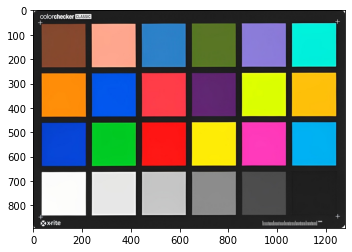

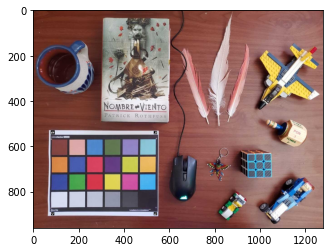

In [52]:
control_img = cv2.imread(root+'original.jpg')
objective_img = cv2.imread(root+name_img)

control_img = cv2.cvtColor(control_img, cv2.COLOR_BGR2RGB)
objective_img = cv2.cvtColor(objective_img, cv2.COLOR_BGR2RGB)

plt.imshow(control_img)
plt.show()
plt.imshow(objective_img)
plt.show()

## Generate ArUco makers

In [49]:
for id in range(1,5):
    img  = get_img(aruco_type, id)
    cv2.imwrite(root+"ID_"+str(id)+"_"+aruco_type+".png", img)

## Objective image with ArUco markers

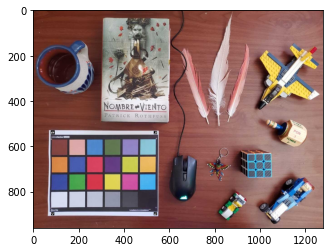

[Inference] ArUco marker ID: 4
Center -> x:540 y:896
[Inference] ArUco marker ID: 3
Center -> x:86 y:896
[Inference] ArUco marker ID: 2
Center -> x:540 y:539
[Inference] ArUco marker ID: 1
Center -> x:86 y:538


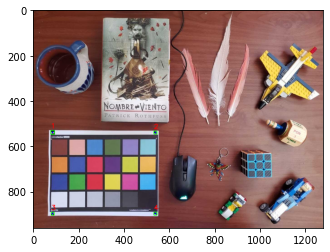

In [50]:
img  = cv2.imread(root+name_img)
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img_detected, centers = detect_aruco_markers(img, aruco_type)
plt.imshow(img_detected)
plt.show()

## Correct Perspective and Orientation

In [24]:
def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost
    return np.array([tl, tr, br, bl], dtype="float32")

In [25]:
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped, rect

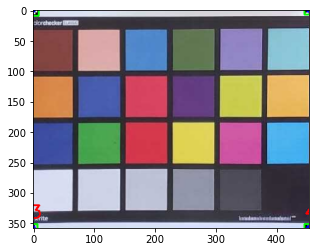

In [26]:
img_detected, rect  = four_point_transform(img_detected, centers.copy())
plt.imshow(img_detected)

0


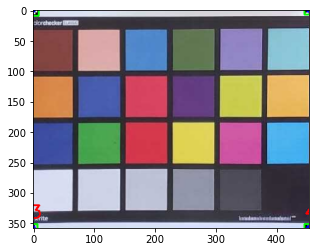

In [27]:
pos = 0

for i in range(len(rect)):
    if rect[i][1] == centers[0][1]  and rect[i][0] == centers[0][0]:
        pos = i
        break

rows, cols, ch = img_detected.shape
print(pos)
if pos ==1:
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),90,1) #(rotation center, degrees, scale)
    img_detected = cv2.warpAffine(img_detected,transform_matrix,(cols,rows)) # (image, transform matrix, image size)
elif pos ==2:
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),180,1) 
    img_detected = cv2.warpAffine(img_detected,transform_matrix,(cols,rows)) 
elif pos ==3:
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1) 
    img_detected = cv2.warpAffine(img_detected,transform_matrix,(cols,rows)) 

plt.imshow(img_detected)

## Get colors from chart

In [28]:
def get_points_from_colors(img, ini_x, div_x, div_y, margin, show_points = False, mark_size = 5):
    n,m,c  = img.shape

    x = np.zeros((24),dtype = "int")
    y = np.zeros((24),dtype = "int")

    index = 0
    for idx, j in enumerate(range(ini_x, m+1, m//div_x)):
        for idx2, i in enumerate(range(0, n,n//div_y)): 
            if idx2>0 and idx2<div_y and len(x)<=24:
                u = j
                if idx == div_x:
                    u = j - (m/margin)
                elif idx == 0:
                    u = j + (m/margin)
                x[index] = u
                y[index] = i
                index+=1
    if  show_points : 
        plt.imshow(img)
        plt.plot(x, y, marker="o", markersize=mark_size, markeredgecolor="black", markerfacecolor="white")
        plt.show()

    points = np.zeros((24,2), dtype = "int")
    points[:,0] = x[:]
    points[:,1] = y[:]
    return points


In [29]:
def get_colors_from_points(points, img, windows_size = 10, show_colors = False):
    matrix = np.zeros((24,3))
    for i in range(len(points)):
        for u in range(points[i][1],points[i][1]+windows_size):
            for v in range(points[i][0],points[i][0]+windows_size):
                matrix[i]+=img[u][v]
        matrix[i]/=float(windows_size*windows_size)
        if show_colors: 
            color = np.zeros((300, 300, 3), dtype=np.uint8)
            color[:,:,0] = matrix[i][0]
            color[:,:,1] = matrix[i][1]
            color[:,:,2] = matrix[i][2]
            plt.axis("off")
            plt.imshow(color.astype("uint8"))
            plt.show()
    return matrix.astype("int")

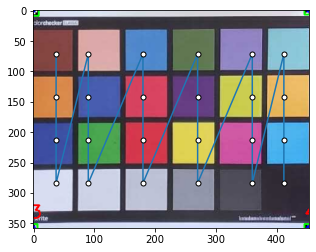

In [30]:
points = get_points_from_colors(img_detected,0,5,5,12, True)
Mo = get_colors_from_points(points,img_detected)

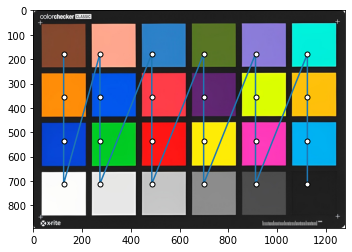

In [31]:
points = get_points_from_colors(control_img,60,6,5,20, True)
Control = get_colors_from_points(points,control_img)

## Optimization 

In [32]:
def f(P):
    global Control
    global Mo

    m = np.reshape(P.copy(),(3,3))
    Mc = np.matmul(Mo,m)
        
    Mc = np.where(Mc > 255, 255, Mc)
    Mc = np.where(Mc < 0 , 0, Mc)
    
    return np.sum(np.abs(Mc-Control))

In [33]:
bounds = [[1,2], [-2,0], [-2,0],
        [-2,0],   [1,2], [-2,0],
        [-2,0],   [-2,0],  [1,2]
        ] 

In [34]:
def color_correction(img, ccm):
    img2 = img.reshape((img.shape[0] * img.shape[1], 3))
    output = np.matmul(img2, ccm)  
    output = np.where(output > 255, 255, output)
    output = np.where(output < 0 , 0, output)
    return output.reshape(img.shape).astype(img.dtype)

In [35]:
val = 0
performance = np.zeros(500)
showProgress = False

def plot(P):
    global val 
    global img 
    global showProgress
    
    Paux = np.reshape(P.copy(),(3,3))
    res = color_correction(img, Paux)
    
    performance[val] = f(P)
    if showProgress:
        clear_output(wait=True)
        print(P)
        print(f(P))
        plt.imshow(res)
        plt.show()
        res = cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
        cv2.imwrite("iterations/DifferentialEvolution/output_"+str(val)+".png", res)
    val+=1

In [36]:
results = np.zeros((3,2))

rep:  1 / 1
(array([ 1.66181   , -0.11292824, -0.22083703, -0.49805985,  1.29749702,
       -0.46103822, -0.16949276, -0.15750791,  1.57329923]), 500, 903.156727566401, 125250)


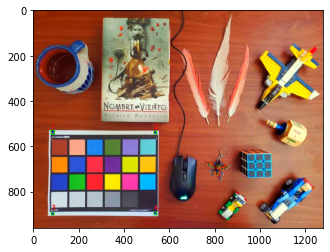

In [37]:
from differential_evolution import differential_evolution

st = time.process_time()
res =  differential_evolution(f, callback = plot, iterations = 500 , bounds = bounds, popsize=250,Cr=0.75, rep=1)
et = time.process_time()
tiempo = et - st

print(res)
plt.imshow(color_correction(img, np.reshape(res[0],(3,3))))

results[0][0] = res[2]
results[0][1] = tiempo

In [38]:
def plot(img_array, titles):
    fig, ax = plt.subplots(1,3, figsize=(12, 10), tight_layout=True)
    for idx, ax_ in enumerate(ax.ravel()):
        ax_.axis('off')
        ax[idx].imshow(img_array[idx])
        ax[idx].set_title(titles[idx])
    plt.show()

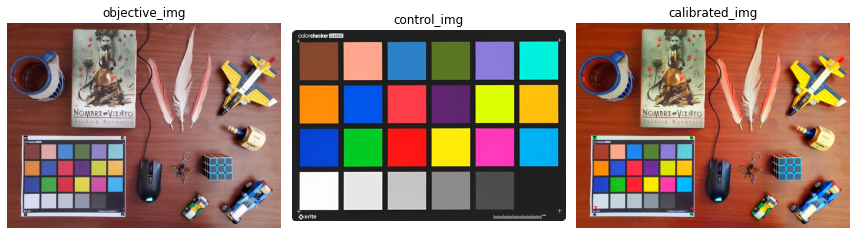

In [39]:
titles = ["objective_img", "control_img", "calibrated_img"]
img_array = [objective_img, control_img, color_correction(img, np.reshape(res[0],(3,3)))]

img_final = color_correction(img, np.reshape(res[0],(3,3)))
img_final = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)

cv2.imwrite(root+"calibrated_img/.png", img_final)
plot(img_array, titles)

<class 'evolutionary_programming.EvolutionaryProgramming.Format'>
P = [ 2.36075256 -0.12084542 -0.22085127 -0.78258946  1.31291236 -0.4762537
 -0.49962102 -0.16281723  1.586915    0.00144195  0.00052911  0.00130776
  0.0006692   0.00145678  0.00055227  0.00187612  0.00122914  0.00219818]
nit = 500
fun = 920.9149203579246
nfev = 250250


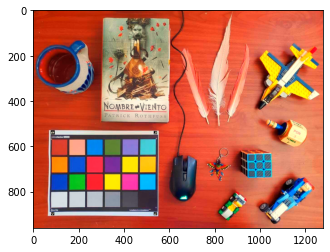

In [41]:
from evolutionary_programming import evolutionary_programming

st = time.process_time()
res = evolutionary_programming(f,bounds,500, popsize=250)
print(res)
et = time.process_time()
tiempo = et - st
results[1][0] = res.fun
results[1][1] = tiempo

img  = cv2.imread(root+name_img)
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(color_correction(img, np.reshape(res.P.copy()[:9],(3,3))))

rep:  1 / 1
(array([ 1.65167793, -0.1273312 , -0.21979086, -0.49184832,  1.32224876,
       -0.48684509, -0.16501251, -0.16564014,  1.59585699]), 500, 903.919160468155, 125250)


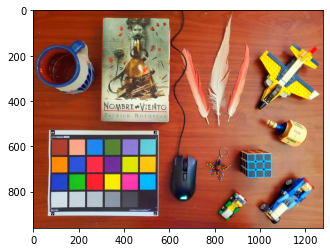

In [43]:
from PSO import particle_swarm_optimization

st = time.process_time()
res = particle_swarm_optimization(f,500,bounds, N = 250)
et = time.process_time()
tiempo = et - st
results[2][0] = res[2]
results[2][1] = tiempo


print(res)

img  = cv2.imread(root+name_img)
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(color_correction(img, np.reshape(res[0].copy(),(3,3))))

In [44]:
#results = pd.DataFrame(results, columns=['Best fitness', 'execution time'], index=['Differential evolution', 'Evolutionary programming', 'Particle swarm optimization'])
#results
#dfi.export(results, 'dataframe.png')

In [45]:
iterations = range(1,501)
plt.plot(iterations,performance, 'g', )
plt.xlabel('iterations')
plt.ylabel('Fitness')
plt.savefig(root+'Performance.png')
plt.close()